In [2]:
%load_ext autoreload
%load_ext watermark

In [3]:
%autoreload 2

In [4]:
%watermark -ntz -p numpy,pandas,sklearn

Thu Aug 25 2022 12:34:20 India Standard Time 

numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1


In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


---
# Exercise 7: Predict Traffic
In this exercise you will develop a model
to predict traffic levels using the dataset
you created in the previous exercise.

## Learning objectives
Objectives which _may_ be met during this exercise.

- I can develop a simple model to predict traffic levels from weather data (_ML 1_)
- I can record model training information to make training reproducible (_ML 1_)

_Refer to the [exercise document](../references/exercise_background.md#development-objectives) for more information on objectives_


---
## Step 1: Load Data

**Tasks:**
- Load the datasets you created in the previous exercise

In [6]:
train_data_path = Path.cwd().resolve().parent /'analysis'/ "data" / "interim" / 'train.csv'
test_data_path = Path.cwd().resolve().parent /'analysis'/ "data" / "interim" / 'test.csv'

In [7]:
# Load train, validation and test datasets
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [8]:
train.head()

,special_day_b,special_day_bo,special_day_norm,special_day_o,special_day_s,weekend,Rainfall (mm),MaxApparentTemp (degC),Counter_avg_traffic,Prev_day_mean,Prev_day_peak,Prev_week_mean,Prev_week_peak,Daily_mean_traffic
0,0,1,0,0,0,0,0.0,7.7,44.91,NaN,NaN,NaN,NaN,47.46
1,0,0,0,1,0,0,0.0,0.4,44.91,47.46,210.0,NaN,NaN,53.50
2,0,0,0,1,0,0,0.0,1.0,44.91,53.50,210.0,NaN,NaN,38.33
3,0,0,0,1,0,1,0.0,2.8,44.91,38.33,120.0,NaN,NaN,44.54
4,0,0,0,1,0,1,0.0,3.4,44.91,44.54,148.0,NaN,NaN,37.42


In [9]:
train['Counter ID'].value_counts()

KeyError: 'Counter ID'

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6399 entries, 0 to 6398
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   special_day_b           6399 non-null   int64  
 1   special_day_bo          6399 non-null   int64  
 2   special_day_norm        6399 non-null   int64  
 3   special_day_o           6399 non-null   int64  
 4   special_day_s           6399 non-null   int64  
 5   weekend                 6399 non-null   int64  
 6   Rainfall (mm)           6399 non-null   float64
 7   MaxApparentTemp (degC)  6399 non-null   float64
 8   Counter_avg_traffic     6399 non-null   float64
 9   Prev_day_mean           6375 non-null   float64
 10  Prev_day_peak           6375 non-null   float64
 11  Prev_week_mean          6231 non-null   float64
 12  Prev_week_peak          6231 non-null   float64
 13  Daily_mean_traffic      6399 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 70

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1377 entries, 0 to 1376
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   special_day_b           1377 non-null   int64  
 1   special_day_bo          1377 non-null   int64  
 2   special_day_norm        1377 non-null   int64  
 3   special_day_o           1377 non-null   int64  
 4   special_day_s           1377 non-null   int64  
 5   weekend                 1377 non-null   int64  
 6   Rainfall (mm)           1377 non-null   float64
 7   MaxApparentTemp (degC)  1377 non-null   float64
 8   Counter_avg_traffic     1377 non-null   float64
 9   Prev_day_mean           1377 non-null   float64
 10  Prev_day_peak           1377 non-null   float64
 11  Prev_week_mean          1377 non-null   float64
 12  Prev_week_peak          1377 non-null   float64
 13  Daily_mean_traffic      1377 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 15

In [10]:
train = train.dropna().reset_index().drop(labels = 'index', axis = 1)

In [11]:
print(train.shape,test.shape)

(6231, 14) (1377, 14)


In [12]:
x_train = train.drop(labels='Daily_mean_traffic',axis=1)
x_test = test.drop(labels='Daily_mean_traffic',axis=1)
y_train = train['Daily_mean_traffic']
y_test = test['Daily_mean_traffic']

In [13]:
x_train.shape

(6231, 13)

---
## Step 2: Set a baseline

To evaluate whether a model is useful or not,
it is important to set baseline performance
against which to compare.
This could be a human prediction
or a simple statistic such as mean traffic.

**Tasks:**
- Develop a simple baseline using the training data
- Score the baseline on the other datasets

In [34]:
# Base Line Score
y_train.mean()

112.68814476007061

In [48]:
len(y_test)

1377

In [42]:
base_prediction_train = [y_train.mean()]*len(y_train)
base_prediction_test = [y_train.mean()]*len(y_test)

In [43]:
len(base_prediction_train)

6231

In [44]:
y_test.mean()

136.69027596223674

In [67]:
# MSE Train
error = 0
for i in range(len(train)) :
    error += (y_train[i] - base_prediction_train[i])**2
print(error/len(y_train))

11454.14482021404


In [49]:
# MSE Test
error = 0
for i in range(len(test)) :
    error += (y_test[i] - base_prediction_test[i])**2
print(error/len(y_test))

16751.855751988303


In [50]:
r2_score(y_test,base_prection_test )

-0.037206944944084164

---
## Step 3: Develop a simple model

**Tasks:**
- Train a simple model on the training dataset
- Evaluate the model on one of the other datasets
    - Should you use `eval` or `test`? Why?

In [68]:
regr = RandomForestRegressor( random_state=0, min_impurity_decrease=0.00001)
regr.fit(x_train, y_train)
print(regr.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 1e-05, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [69]:
print(regr.score(x_train, y_train))

print(regr.score(x_test, y_test))

0.9975021010186951
0.9848278280842693


---
## Step 4: Develop more models

**Tasks:**
- Repeat step `3` with a number of different, simple models
- Which one looks the most promising? Can you evaluate why?

---
## Step 5: Tune best model
- Tune the hyperparameters of the most promising model you tried
- Is the difference between your evaluation and training score good enough?

In [70]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [72]:
rf_ = RandomizedSearchCV(estimator = RandomForestRegressor( random_state=0, min_impurity_decrease=0.00001),
                     param_distributions= random_grid, cv = 3, verbose = 2,n_jobs = -1)

In [73]:
rf_.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(min_impurity_decrease=1e-05,
                                                   random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [75]:
f_model = rf_.best_estimator_

In [76]:
f_model.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 1e-05,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [77]:
print(f_model.score(x_train, y_train))

print(f_model.score(x_test, y_test))

0.9978010334821689
0.9864686820932378


In [84]:
train_predictions = list(f_model.predict(x_train))
test_predictions = list(f_model.predict(x_test))

In [85]:
# MSE Train
error = 0
for i in range(len(train)) :
    error += (y_train[i] - train_predictions[i])**2
print(error/len(y_train))

25.18728095003912


In [82]:
# MSE Test
error = 0
for i in range(len(test)) :
    error += (y_test[i] - predictions[i])**2
print(error/len(y_test))

218.87926230986758


In [86]:
importances = f_model.feature_importances_

importance_dict = {'Feature' : list(x_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

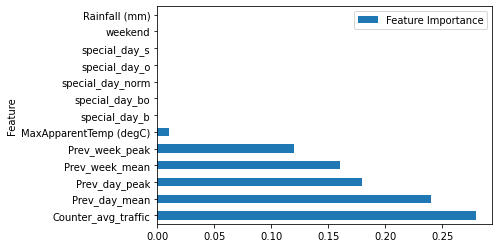

In [95]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],4)
importance_df.sort_values(by=['Feature Importance'],ascending=False).set_index('Feature').plot(kind = 'barh')

---
## Step 6: Evaluate

**Tasks:**
- When you are happy with the model's performance, evaluate it on the final dataset
- Does it beat the baseline?
    - If not, why? At which exercise/step should you return to when re-developing the model?

---
## Step 7: Save the model

**Tasks:**
- Save the model using `pickle` to a `models/` directory in the project root
- Write a document containing model training and performance information

---
# Review

After this exercise:

- [ ] I can develop a simple model to predict traffic levels from weather data (_ML 1_)
- [ ] I can record model training information to make training reproducible (_ML 1_)